# Домашнее задание 4

Это домашнее задание по материалам второго семинаров. Дедлайн по отправке - 23:55 3 марта. 

Домашнее задание выполняется в этом же Jupyter Notebook'e и присылается мне на почту: __beznosikov.an@phystech.edu__.

Решение каждой задачи необходимо поместить после её условия.

Файл должен называться: Фамилия_Имя_Optimization_HW_4

При полном запуске Вашего решения (Kernel -> Restart & Run All) все ячейки должны выполняться без ошибок. 

## Задача 1

Рассмотрим задачу минимизации:
\begin{equation}
\min_{x \in \triangle_d} f(x) = \frac{1}{2}x^T A x,
\end{equation}
где в качестве матрицы $A$ - случайная матрица (уже умеем генерировать) с $L =1000$, $\mu = 1$, а $\triangle_d$ - вероятностный симплекс:
$$
\triangle_d = \{x ~|~ x_i \geq 0, \sum_{i=1}^d x_i = 1\}.
$$

__(а)__ Для такой задачи напишите итерацию зеркального спуска с дивергенцией Брегмана, порожденной энтропийной функцией. Найдите выражение для итерации метода в явном виде (без подсчетов $\arg\min$).

In [6]:
import time
import numpy as np 
import matplotlib.pyplot as plt 
import math

In [7]:
#matrix generation, from first homework
import numpy as np 
from numpy import linalg 

def rvs(dim=3):
     random_state = np.random
     H = np.eye(dim)
     D = np.ones((dim,))
     for n in range(1, dim):
         x = random_state.normal(size=(dim-n+1,))
         D[n-1] = np.sign(x[0])
         x[0] -= D[n-1]*np.sqrt((x*x).sum())
         # Householder transformation
         Hx = (np.eye(dim-n+1) - 2.*np.outer(x, x)/(x*x).sum())
         mat = np.eye(dim)
         mat[n-1:, n-1:] = Hx
         H = np.dot(H, mat)
     D[-1] = (-1)**(1-(dim % 2))*D.prod()
     H = (D*H.T).T
     return H
    
def generate_matrix(d, m, L):  
    A = np.eye(d) 
    A[0, 0] = L
    A[1, 1] = m
    S = rvs(d) 
    A = np.dot(np.linalg.inv(S), np.dot(A, S))
    return A 

Шаг зеркального спуска c дивергенцией Брегмана, порожденной энтропийной функцией: 
    $$ x^{k + 1} =  argmin_{x \in \triangle_{d}} (\nabla f(x^{k}), x) + \sum_{i}^{d} x_{i}ln \cfrac{x_{i}}{x_{i}^{k}}$$ 

Воспользуемся тем, что норма к симплекс методу есть вектор, состоящий из единиц.  
Тогда, градиент в точке $x^{k + 1}$ должен быть параллелен ей. То есть получаем, что: 
$$\nabla f(x_{i}^{k + 1}) = \nabla f(x_{i}^{k}) + ln\cfrac{x_{i}^{k + 1}}{x_{i}^{k}} + 1 = \alpha \cdot 1$$

Отсюда найдем $$x_{i}^{k + 1} = x_{i}^{k}exp(-\nabla f(x_{i}^{k}))exp(\alpha - 1)$$

Константу найдем из условия того, что $$\sum_{i = 1}^{d} x_{i}^{k + 1} = 1$$

$$exp(\alpha - 1) = \cfrac{1}{\sum_{i = 1}^{d} x_{i}^{k}exp(-\nabla f(x_{i}^{k}))}$$

$$x_{i}^{k + 1} = \cfrac{x_{i}^{k}exp(-\nabla f(x_{i}^{k}))}{\sum_{i = 1}^{d}x_{i}^{k}exp(-\nabla f(x_{i}^{k}))}$$

__(б)__ Реализуйте метод зеркального спуска из пункта (а). Постройте для него график сходимости по времени и по итерациям. В качестве критерия сходимости используйте:
$$
\text{gap}(x^k) = \max_{y \in \triangle_d} \langle \nabla f(x^k), x^k - y \rangle,
$$
или усредненную версию $\frac{1}{k} \sum_{i=1}^k \text{gap}(x^i)$. Найдите выражение в явном виде для подсчета $\text{gap}(x^k)$.

Пользуясь тем, что мы работаем на вероятностном симплексе, мы можем, не записывая ККТ, сделать вывод, что: 

$$gap(x^{k}) = \nabla f^{T}(x^{k})x^{k} - min_{i}(\nabla f(x_{i}^{k}))$$

In [8]:
import math  
eps = 1e-6
class MirrorDescent: 
    def __init__(self, d, alpha = 1e-3, max_iter = 10000): 
        self.d = d 
        self.A = generate_matrix(self.d, 1, 1000) 
        self.x = None 
        self.gap_history = []  
        self.max_iter = max_iter 
        self.alpha = alpha  
        self.time_history = []
        
    def f(self): 
        return 1/2 * np.dot(x.T, np.dot(A, x))
        
    def grad_f(self): 
        return 1/2 * np.dot((self.A.T + self.A), self.x)
    
    def fit(self):  
        self.x = np.ones(self.d) 
        self.x /= self.d
        time_start = time.time() 
        for i in range(self.max_iter): 
            g = self.grad_f() 
            
            self.x = self.x * np.exp(-self.alpha * g) / np.sum(self.x * np.exp(-self.alpha * g))
            self.gap_history.append(np.dot(g.T, self.x) - np.min(g))  
            self.time_history.append(time.time() - time_start)

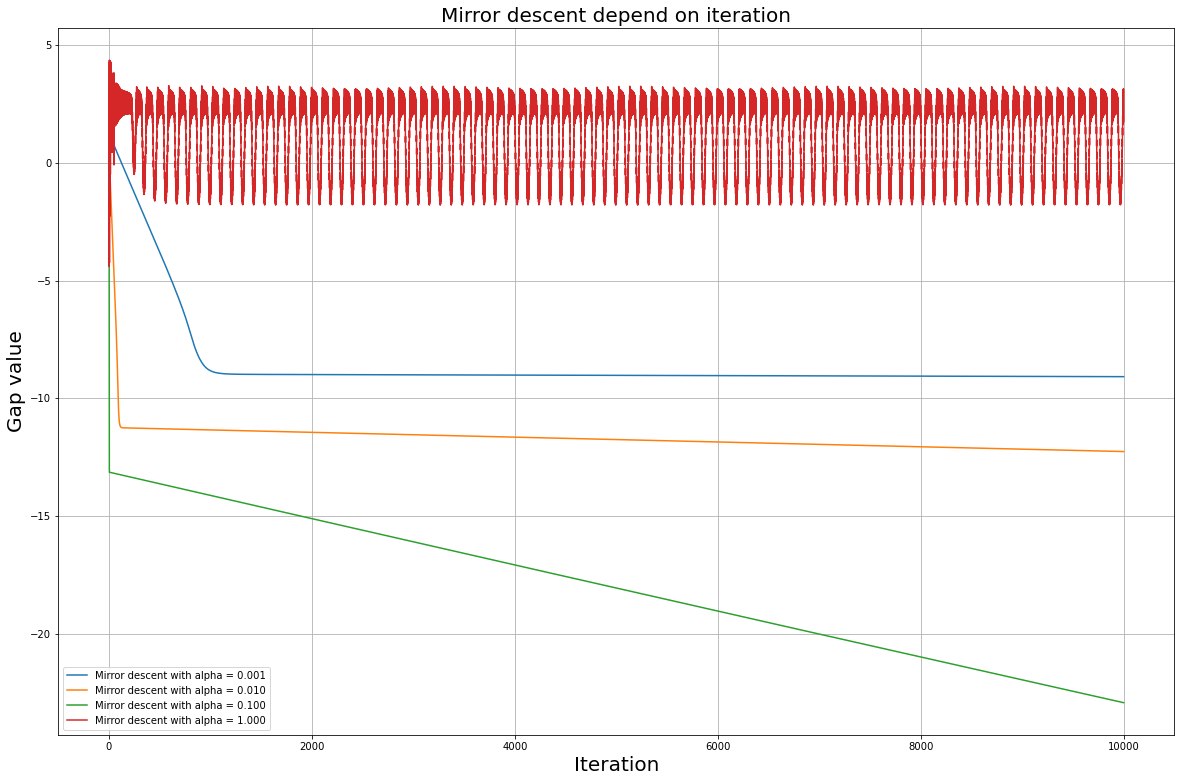

In [9]:
import matplotlib.pyplot as plt  
plt.figure(figsize=(20, 13)) 
plt.title('Mirror descent depend on iteration', fontsize=20) 
alpha = [0.001, 0.01, 0.1, 1] 
for a in alpha:  
    md = MirrorDescent(100, a) 
    md.fit()
    plt.plot(range(md.max_iter), np.log(md.gap_history), label='Mirror descent with alpha = %5.3f' % a)  
plt.xlabel('Iteration', fontsize=20)  
plt.ylabel('Gap value', fontsize=20)
plt.legend()
plt.grid() 
plt.show()

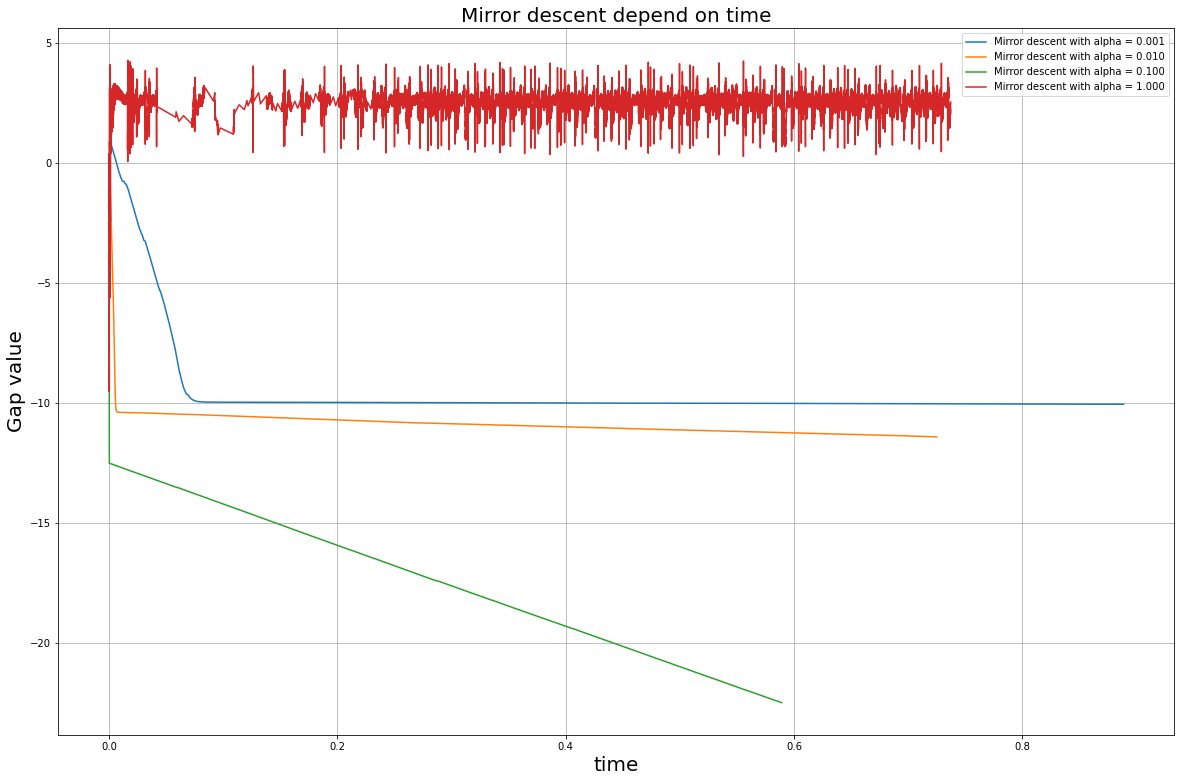

In [10]:
import time  
plt.figure(figsize=(20, 13)) 
plt.title('Mirror descent depend on time', fontsize=20) 
alpha = [0.001, 0.01, 0.1, 1] 
for a in alpha:  
    md = MirrorDescent(100, a) 
    md.fit()
    plt.plot(md.time_history, np.log(md.gap_history), label='Mirror descent with alpha = %5.3f' % a)  
plt.xlabel('time', fontsize=20)  
plt.ylabel('Gap value', fontsize=20)
plt.legend()
plt.grid() 
plt.show()

__(в)__ Для этой же задачи напишите итерацию метода Франка-Вульфа. Реализуйте этот метод. Постройте для него график сходимости по времени и по итерациям. Добавьте эти графики к графикам для зеркального спуска. Сделайте вывод.

In [11]:
class Frank_Wolfie: 
    def __init__(self, d, max_iter=10000): 
        self.d = d  
        self.max_iter = max_iter 
        self.A = generate_matrix(self.d, 1, 1000)  
        self.gap_history = [] 
        self.time_history = [] 
        self.x = None  
        
    def grad_f(self): 
        return 1/2 * np.dot((self.A.T + self.A), self.x) 
    
    def fit(self): 
        self.x = np.ones(self.d) 
        s = np.zeros(self.d)   
        s /= self.d
        time_start = time.time()
        alpha = 1
        
        for i in range(self.max_iter):   
            alpha = 2/(i + 2)
            g = self.grad_f()   
            
            min_val = np.min(g)
            min_idx = np.where(g == min_val)[0]
            s[min_idx] = 1 / len(min_idx)  
            
            self.x = (1 - alpha) * self.x + alpha * s 
            
            self.gap_history.append(np.dot(g.T, self.x) - np.min(g)) 
            self.time_history.append(time.time() - time_start) 
            s = np.zeros(self.d)

In [12]:
fw = Frank_Wolfie(100) 
fw.fit()

In [13]:
md = MirrorDescent(100) 
md.fit()

/tmp/ipykernel_305528/3044705612.py:3: RuntimeWarning: divide by zero encountered in log
  plt.plot(range(fw.max_iter), np.log(fw.gap_history), label='Frank_Wolfie')


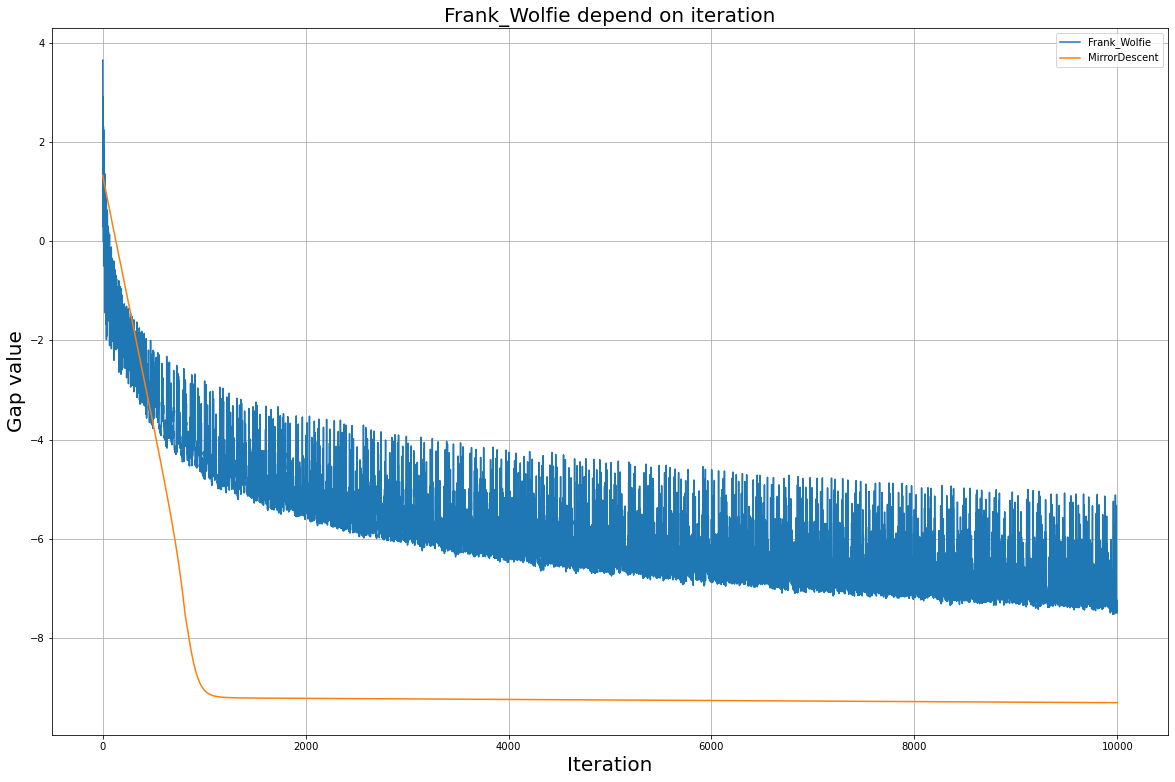

In [14]:
plt.figure(figsize=(20, 13)) 
plt.title('Frank_Wolfie depend on iteration', fontsize=20) 
plt.plot(range(fw.max_iter), np.log(fw.gap_history), label='Frank_Wolfie')   
plt.plot(range(md.max_iter), np.log(md.gap_history), label='MirrorDescent')
plt.xlabel('Iteration', fontsize=20)  
plt.ylabel('Gap value', fontsize=20)
plt.legend()
plt.grid() 
plt.show()

/tmp/ipykernel_305528/601294993.py:3: RuntimeWarning: divide by zero encountered in log
  plt.plot(fw.time_history, np.log(fw.gap_history), label='Frank_Wolfie')


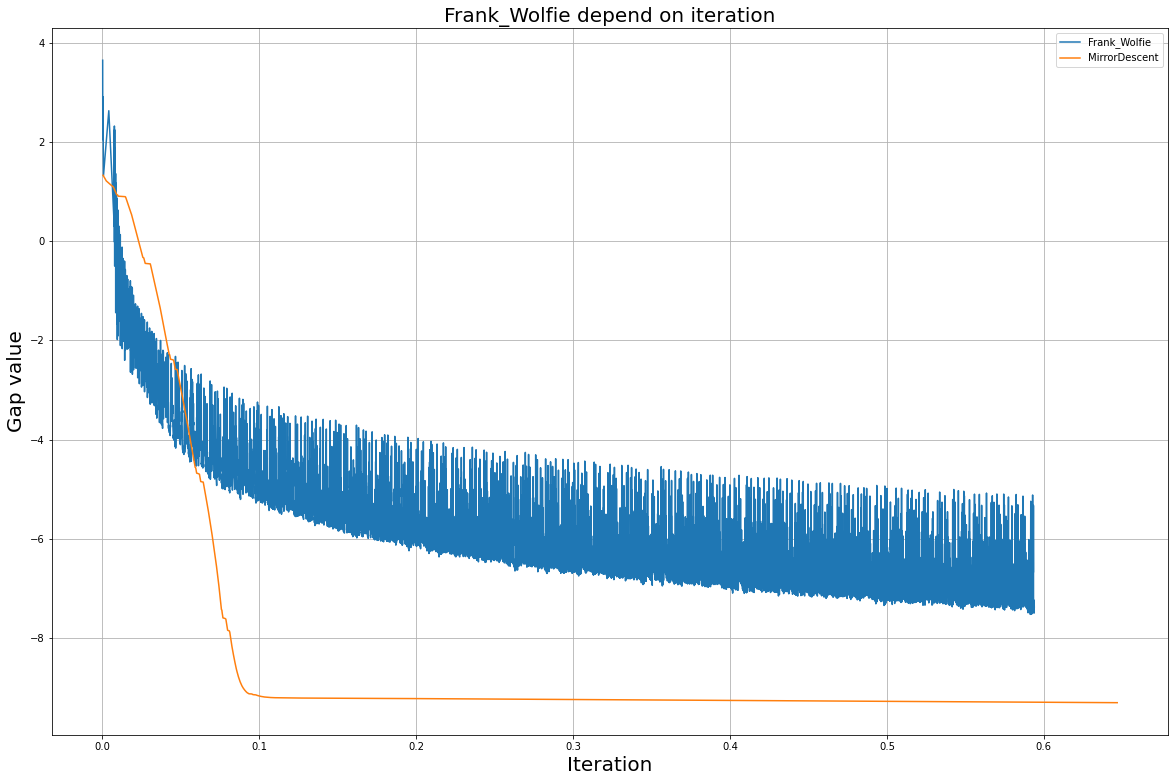

In [15]:
plt.figure(figsize=(20, 13)) 
plt.title('Frank_Wolfie depend on iteration', fontsize=20) 
plt.plot(fw.time_history, np.log(fw.gap_history), label='Frank_Wolfie')   
plt.plot(md.time_history, np.log(md.gap_history), label='MirrorDescent')
plt.xlabel('Iteration', fontsize=20)  
plt.ylabel('Gap value', fontsize=20)
plt.legend()
plt.grid() 
plt.show()

__Бонусные пункты__

__(г)__ Реализуйте метод градиентного спуска для нашей задачи. Для этого найдите в Интернете алгоритм евклидовой проекции на вероятностный симплекс. Постройте для градиентного спуска с евклидовой проекцией график сходимости по времени и по итерациям. Добавьте эти графики к графикам для зеркального спуска и метода Франка-Вульфа. Сделайте вывод.

In [ ]:
#ответ

__(д)__ В [работе](https://sci-hub.ru/https://doi.org/10.1137/140992382) представлена ускоренная версия метода Франка-Вульфа (Алгоритм 2 для сильно выпуклой задачи). Он лучше с точки зрения теоретической сходимости по числу вызовов градиента. Реализуйте Алгоритм 2 для нашей задачи. Постройте график сходимости по времени и по количеству подсчетов $\nabla f$ (для предыдущих методов это было эквивалетно итерациям). Добавьте эти графики к графикам для остальных методов которые были получены выше. Сделайте вывод.

In [ ]:
#ответ